In [1]:
import os
import glob
import sys
import argparse
from tqdm import tqdm
import numpy as np
from sklearn.neighbors import KDTree
import h5py
import pyproj
import pandas as pd
import multiprocessing
from contextlib import contextmanager
import geopandas as gpd
from shapely.geometry import Polygon
import traceback
import h3pandas
import ee
import geemap
import rasterio
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# read LVIS crossovers

In [42]:
def parallel_run(fname):
    temp_df = pd.read_parquet(fname)
    return temp_df

fnames = glob.glob('tiles/*.parquet')
xovers = []
n_cpus = 10
pool = multiprocessing.Pool(n_cpus)
for temp_df in tqdm(pool.imap_unordered(parallel_run, fnames), total=len(fnames), position=0):
    xovers.append(temp_df)
pool.close()
xovers = pd.concat(xovers, ignore_index=True)

100%|█████████████████████| 322/322 [01:34<00:00,  3.40it/s]


In [43]:
mask = np.logical_or(xovers.ZG_1>xovers.ZG_2+xovers.RH100_2, xovers.ZG_2>xovers.ZG_1+xovers.RH100_1) 
xovers = xovers[~mask].reset_index(drop=True)

In [7]:
for item in xovers.columns:
    print(item)

AZIMUTH_1
CHANNEL_L1B_1
CHANNEL_RH_1
CHANNEL_ZG_1
COMPLEXITY_1
GLAT_1
GLON_1
HLAT_1
HLON_1
INCIDENTANGLE_1
LAT0_1
LAT1023_1
LFID_1
LON0_1
LON1023_1
RANGE_1
RH10_1
RH100_1
RH15_1
RH20_1
RH25_1
RH30_1
RH35_1
RH40_1
RH45_1
RH50_1
RH55_1
RH60_1
RH65_1
RH70_1
RH75_1
RH80_1
RH85_1
RH90_1
RH95_1
RH96_1
RH97_1
RH98_1
RH99_1
RXWAVE_1
SHOTNUMBER_1
SIGMEAN_1
TIME_1
TLAT_1
TLON_1
TXWAVE_1
Z0_1
Z1023_1
ZG_1
ZH_1
ZT_1
AZIMUTH_2
CHANNEL_RH_2
CHANNEL_ZG_2
CHANNEL_ZT_2
COMPLEXITY_2
GLAT_2
GLON_2
HLAT_2
HLON_2
INCIDENTANGLE_2
LAT0_2
LAT1023_2
LFID_2
LON0_2
LON1023_2
RANGE_2
RH10_2
RH100_2
RH15_2
RH20_2
RH25_2
RH30_2
RH35_2
RH40_2
RH45_2
RH50_2
RH55_2
RH60_2
RH65_2
RH70_2
RH75_2
RH80_2
RH85_2
RH90_2
RH95_2
RH96_2
RH97_2
RH98_2
RH99_2
RXWAVE_2
SENSITIVITY_2
SHOTNUMBER_2
SIGMEAN_2
TIME_2
TLAT_2
TLON_2
TXWAVE_2
Z0_2
Z1023_2
ZG_2
ZH_2
ZT_2


In [44]:
xovers = xovers[['GLAT_1', 'GLON_1', 'INCIDENTANGLE_1', 'LFID_1', 'RH98_1', 'SHOTNUMBER_1', 'ZG_1', 'ZT_1', 'Z1023_1', 'Z0_1', 'RXWAVE_1', 'GLAT_2', 'GLON_2', 'INCIDENTANGLE_2', 'LFID_2', 'RH98_2', 'SHOTNUMBER_2', 'ZG_2', 'ZT_2', 'Z1023_2', 'Z0_2', 'RXWAVE_2']].copy()
xovers

,GLAT_1,GLON_1,INCIDENTANGLE_1,LFID_1,RH98_1,SHOTNUMBER_1,ZG_1,ZT_1,Z1023_1,Z0_1,...,GLON_2,INCIDENTANGLE_2,LFID_2,RH98_2,SHOTNUMBER_2,ZG_2,ZT_2,Z1023_2,Z0_2,RXWAVE_2
0,0.484616,9.571039,5.881130,1657455189,2.31,12657652,12.77,15.75,-39.418900,113.126747,...,9.571031,4.625141,1660091137,2.80,5934968,11.94,16.75,-40.677345,112.124573,"[58.0, 60.0, 59.0, 60.0, 59.0, 59.0, 60.0, 59...."
1,0.625975,10.154900,3.702505,1657440017,26.10,940477,575.79,603.91,523.733276,676.758118,...,10.154893,3.334551,1660086071,25.84,4741584,577.51,604.51,526.681213,679.728271,"[58.0, 59.0, 58.0, 59.0, 57.0, 58.0, 57.0, 58...."
2,0.626570,10.155087,3.962198,1657440018,18.17,940929,593.69,613.14,541.281128,694.260376,...,10.155104,2.833752,1660086071,16.58,4741731,595.54,613.16,548.837158,701.955566,"[60.0, 60.0, 59.0, 57.0, 56.0, 58.0, 59.0, 58...."
3,0.623407,10.175788,4.834422,1657440018,35.63,965465,382.58,421.04,338.668121,491.468750,...,10.175784,1.457380,1660091036,14.83,2397868,409.08,424.70,360.652618,513.906494,"[58.0, 58.0, 60.0, 61.0, 61.0, 62.0, 63.0, 62...."
4,0.623372,10.175405,4.834843,1657440018,21.28,965016,427.51,451.03,371.569458,524.369995,...,10.175418,1.447827,1660091036,14.53,2398088,428.61,444.19,384.979340,538.233948,"[59.0, 60.0, 61.0, 60.0, 60.0, 59.0, 58.0, 60...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475865,0.053478,9.816588,2.525975,1657451148,5.62,9915735,12.28,19.17,-39.754005,113.442520,...,9.816570,2.414086,1660095222,5.20,14910356,12.42,19.50,-39.868389,113.297905,"[60.0, 59.0, 58.0, 58.0, 58.0, 57.0, 58.0, 59...."
1475866,0.052674,9.816949,2.790083,1657451114,16.62,7655512,13.59,32.83,-42.256020,110.907784,...,9.816957,3.167378,1660095222,13.17,14910363,13.70,30.94,-41.292744,111.776207,"[60.0, 60.0, 60.0, 60.0, 57.0, 57.0, 57.0, 58...."
1475867,0.052559,9.817000,1.676689,1657451148,8.92,9915893,13.86,25.55,-41.502560,111.776390,...,9.817013,3.275456,1660095222,9.13,14910364,13.66,26.75,-42.295677,110.757156,"[58.0, 58.0, 62.0, 61.0, 62.0, 60.0, 59.0, 59...."
1475868,0.052100,9.817223,3.308885,1657451114,13.17,7655694,13.55,29.64,-43.166214,109.924522,...,9.817236,3.708803,1660095222,11.70,14910368,13.46,29.08,-41.126217,111.856590,"[59.0, 59.0, 58.0, 60.0, 58.0, 58.0, 59.0, 59...."


# rh recalculation

In [45]:
def plot_scatter(x_data, y_data, ax, x_label='x_data', y_label='y_data', title='x vs y', bins=200, min_limit=0, max_limit=100, vmax=10):
    # min_limit = np.min([x_data.min(), y_data.min()])
    hp = ax.hist2d(x_data, y_data, bins=bins, cmin=1, vmax=vmax, cmap='jet', range=[(min_limit,max_limit),(min_limit,max_limit)])
    
    r2 = np.corrcoef(x_data, y_data)[0, 1]**2
    rmse = np.sqrt(mean_squared_error(x_data, y_data))
    # sae = np.sum(np.abs(x_data-y_data))
    textstr = f'R2={r2:.02f} \nRMSE(m)={rmse:.02f} \nN={len(x_data)}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    ax.set_aspect('equal')
    ax.axline((0, 0), slope=1, color="black", linewidth=0.7)
    ax.set_xlim(min_limit, max_limit)
    ax.set_ylim(min_limit, max_limit)
    
    inset_ax = inset_axes(ax,
                          width="2%",  # width of colorbar relative to parent plot
                          height="50%",  # height of colorbar relative to parent plot
                          loc='lower right',  # location of the colorbar
                          bbox_to_anchor=(-0.08, 0.02, 1, 1),  # Bounding box to anchor the colorbar
                          bbox_transform=ax.transAxes,
                          borderpad=0)
    
    colorbar = plt.colorbar(hp[3], cax=inset_ax, shrink=0.3)
    colorbar.set_label('Density')

In [46]:
xovers['RHE98_1'] = xovers['ZG_1'] + xovers['RH98_1']
xovers['RHE98_2'] = xovers['ZG_2'] + xovers['RH98_2']

delta = xovers['RHE98_2'] - xovers['RHE98_1']
xovers['delta'] = delta

xovers['RH98_2_new'] = xovers['RH98_1'] + delta

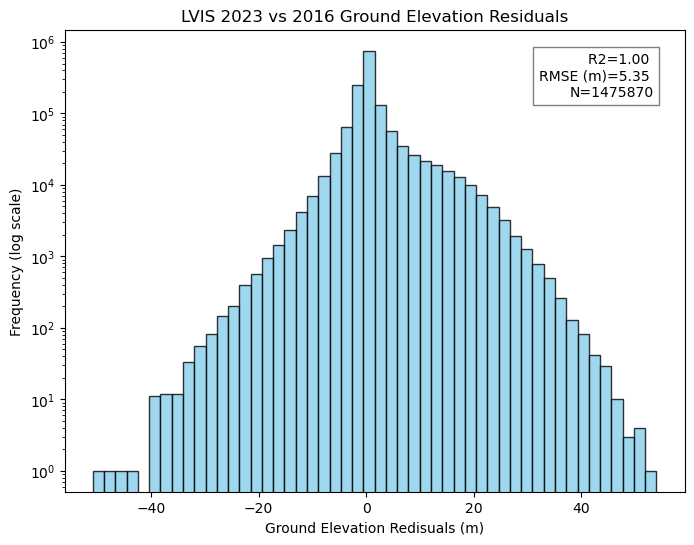

In [47]:
grd_error = xovers['ZG_2'].values - xovers['ZG_1'].values

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('LVIS 2023 vs 2016 Ground Elevation Residuals')
ax.set_xlabel('Ground Elevation Redisuals (m)')
ax.set_ylabel('Frequency (log scale)')

r2 = np.corrcoef(xovers['ZG_1'].values, xovers['ZG_2'].values)[0, 1]**2
rmse = np.sqrt(mean_squared_error(xovers['ZG_1'].values, xovers['ZG_2'].values))
ax.hist(grd_error, color='skyblue', edgecolor='black', alpha=0.8, bins=50, log=True)
# ax.set_xlim(min(data1.min(), data2.min()), max(data1.max(), data2.max()))
textstr = f'R2={r2:.02f} \nRMSE (m)={rmse:.02f} \nN={len(xovers)}'
ax.text(0.95, 0.95, textstr, 
                        transform=ax.transAxes, ha='right', va='top', 
                        fontsize=10, bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
plt.show()

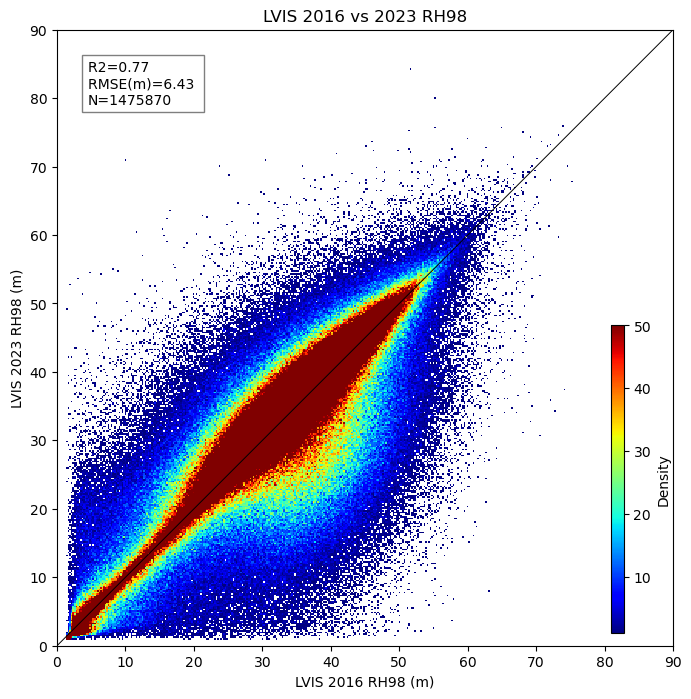

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_scatter(xovers['RH98_1'].values, xovers['RH98_2'].values, ax, x_label='LVIS 2016 RH98 (m)', y_label='LVIS 2023 RH98 (m)', title='LVIS 2016 vs 2023 RH98', bins=400, min_limit=0, max_limit=90, vmax=50)
plt.show()

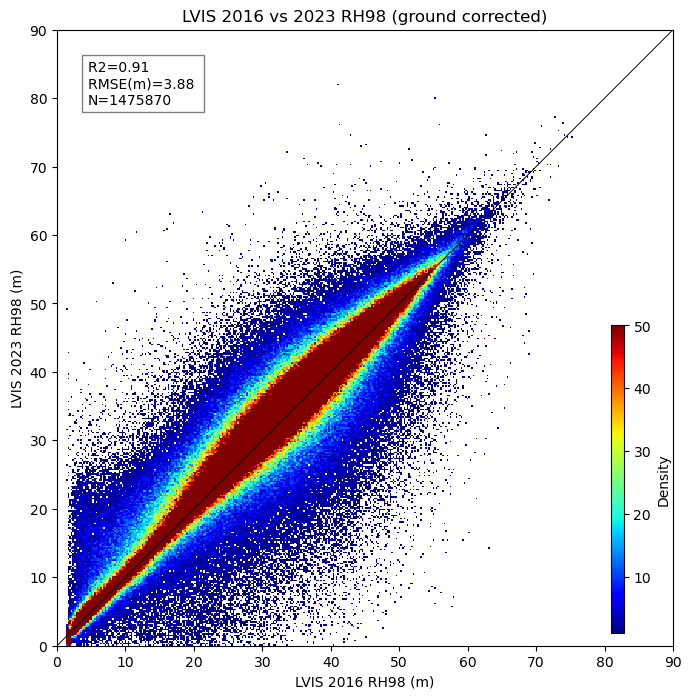

In [49]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_scatter(xovers['RH98_1'].values, xovers['RH98_2_new'].values, ax, x_label='LVIS 2016 RH98 (m)', y_label='LVIS 2023 RH98 (m)', title='LVIS 2016 vs 2023 RH98 (ground corrected)', bins=400, min_limit=0, max_limit=90, vmax=50)
plt.show()

# ground outliers

In [50]:
def plot_lvis(ind, change=False):
    INCIDENTANGLE_1 = xovers['INCIDENTANGLE_1'].iloc[ind]
    ZG_1 = xovers['ZG_1'].iloc[ind]
    ZT_1 = xovers['ZT_1'].iloc[ind]
    waveform_1 = xovers['RXWAVE_1'].iloc[ind].astype('float')
    wfCount_1 = len(waveform_1)
    Z0_1 = xovers['Z0_1'].iloc[ind]
    Z1023_1 = xovers['Z1023_1'].iloc[ind]
    RH100_1 = xovers['RH98_1'].iloc[ind]
    # RH10_1 = xovers['RH10_1'].iloc[ind]
    # RH50_1 = xovers['RH50_1'].iloc[ind]
    zstretch_1 = np.add(Z1023_1, np.multiply(range(wfCount_1, 0, -1),((Z0_1 - Z1023_1)/int(wfCount_1 - 1))))

    INCIDENTANGLE_2 = xovers['INCIDENTANGLE_2'].iloc[ind]
    ZG_2 = xovers['ZG_2'].iloc[ind]
    ZT_2 = xovers['ZT_2'].iloc[ind]
    waveform_2 = xovers['RXWAVE_2'].iloc[ind].astype('float')
    wfCount_2 = len(waveform_2)
    Z0_2 = xovers['Z0_2'].iloc[ind]
    Z1023_2 = xovers['Z1023_2'].iloc[ind]
    RH100_2 = xovers['RH98_2'].iloc[ind]
    # RH10_2 = xovers['RH10_2'].iloc[ind]
    # RH50_2 = xovers['RH50_2'].iloc[ind]
    zstretch_2 = np.add(Z1023_2, np.multiply(range(wfCount_2, 0, -1),((Z0_2 - Z1023_2)/int(wfCount_2 - 1))))

    waveform_1 = (waveform_1-waveform_1.min()) / (waveform_1.max()-waveform_1.min())
    waveform_2 = (waveform_2-waveform_2.min()) / (waveform_2.max()-waveform_2.min())

    print(RH100_1, RH100_2)
    # print(RH50_1, RH50_2)
    print(INCIDENTANGLE_1, INCIDENTANGLE_2)

    plt.figure(figsize=(6, 7))
    plt.plot(waveform_1, zstretch_1, color='dodgerblue', linewidth=2, label='LVIS 2016')
    plt.axhline(ZG_1, color='dodgerblue', linestyle='--', linewidth=1.4, label='LVIS 2016 Ground')
    # plt.axhline(ZG_1+RH50_1, color='dodgerblue', linestyle='-.', linewidth=1.4, label='LVIS 2016 RH50')
    plt.axhline(ZG_1+RH100_1, color='dodgerblue', linestyle='dotted', linewidth=1.4, label='LVIS 2016 RH100')
    
    plt.plot(waveform_2+1, zstretch_2, color='green', linewidth=2, label='LVIS 2023')
    plt.axhline(ZG_2, color='green', linestyle='--', linewidth=1.4, label='LVIS 2023 Ground')
    # plt.axhline(ZG_2+RH50_2, color='green', linestyle='-.', linewidth=1.4, label='LVIS 2023 RH50')
    plt.axhline(ZG_2+RH100_2, color='green', linestyle='dotted', linewidth=1.4, label='LVIS 2023 RH100')

    
    plt.xlabel('Normalized Amplitude')
    plt.ylabel('Elevation (m)')

    if change:
        plt.title(f'LVIS Gabon 2023 vs 2016, lossyear={xovers.GLAD_lossyear.iloc[ind]}, gain={xovers.GLAD_gain.iloc[ind]}, loss={xovers.GLAD_loss.iloc[ind]}')
    else:
        plt.title(f'LVIS Gabon 2023 vs 2016')
        
    # plt.ylim(7, 28)
    plt.legend()
    plt.tight_layout()
    plt.show()

25.65 24.46
3.737522 4.5164433


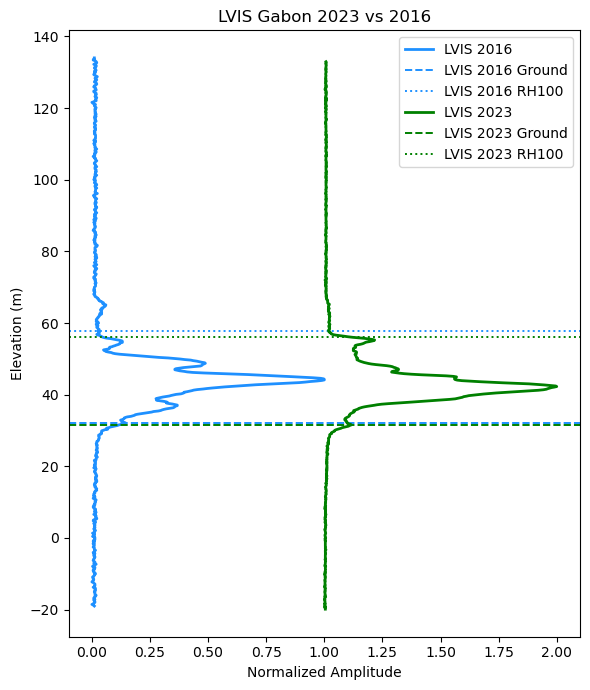

In [51]:
inds = np.argsort(np.abs(grd_error))[::-1]
ind = inds[16000] 
ind = 992521 # 987799, 992521
plot_lvis(ind) # 49, 87, 67, 59

In [52]:
print(xovers['RH98_2_new'].min())
print(xovers['RH98_2_new'].max())

-5.289999999999999
82.12000000000002


In [53]:
mask = xovers['RH98_2_new']>0
xovers = xovers[mask].reset_index(drop=True)

In [59]:
print(xovers['RH98_2_new'].min())
print(xovers['RH98_2_new'].max())

1.1102230246251565e-15
82.12000000000002


# INCIDENTANGLE filtering

In [55]:
inc_diff = np.abs(xovers['INCIDENTANGLE_1'].values - xovers['INCIDENTANGLE_2'].values)

5.4789906
48.2 49.58
0.20849231 5.687483


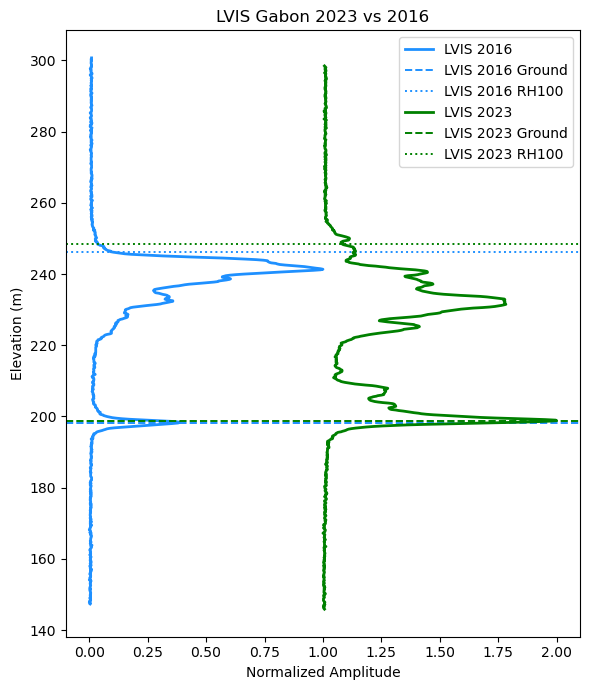

In [56]:
ind = np.argsort(inc_diff)[::-1][677]
print(inc_diff[ind])
plot_lvis(ind) # 49, 87, 67, 59

In [57]:
xovers = xovers[inc_diff<2].reset_index(drop=True)
xovers

,GLAT_1,GLON_1,INCIDENTANGLE_1,LFID_1,RH98_1,SHOTNUMBER_1,ZG_1,ZT_1,Z1023_1,Z0_1,...,SHOTNUMBER_2,ZG_2,ZT_2,Z1023_2,Z0_2,RXWAVE_2,RHE98_1,RHE98_2,delta,RH98_2_new
0,0.484616,9.571039,5.881130,1657455189,2.31,12657652,12.77,15.75,-39.418900,113.126747,...,5934968,11.94,16.75,-40.677345,112.124573,"[58.0, 60.0, 59.0, 60.0, 59.0, 59.0, 60.0, 59....",15.08,14.74,-0.34,1.97
1,0.625975,10.154900,3.702505,1657440017,26.10,940477,575.79,603.91,523.733276,676.758118,...,4741584,577.51,604.51,526.681213,679.728271,"[58.0, 59.0, 58.0, 59.0, 57.0, 58.0, 57.0, 58....",601.89,603.35,1.46,27.56
2,0.626570,10.155087,3.962198,1657440018,18.17,940929,593.69,613.14,541.281128,694.260376,...,4741731,595.54,613.16,548.837158,701.955566,"[60.0, 60.0, 59.0, 57.0, 56.0, 58.0, 59.0, 58....",611.86,612.12,0.26,18.43
3,0.628111,10.173039,3.314303,1657440018,30.08,962943,307.82,339.85,264.800140,417.887939,...,2399445,321.15,340.52,270.067841,422.754150,"[59.0, 59.0, 60.0, 59.0, 59.0, 59.0, 60.0, 61....",337.90,339.47,1.57,31.65
4,0.628100,10.172830,3.300136,1657440018,35.54,962718,303.58,341.51,254.117752,407.207733,...,2399448,318.17,344.07,267.130615,419.812225,"[58.0, 59.0, 59.0, 59.0, 59.0, 58.0, 58.0, 59....",339.12,342.61,3.49,39.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004791,0.053588,9.816513,1.960862,1657451114,6.81,7655299,11.77,20.83,-40.816814,112.438034,...,14910355,12.34,20.02,-39.725353,113.452667,"[58.0, 60.0, 59.0, 58.0, 58.0, 57.0, 57.0, 58....",18.58,17.96,-0.62,6.19
1004792,0.053478,9.816588,2.525975,1657451148,5.62,9915735,12.28,19.17,-39.754005,113.442520,...,14910356,12.42,19.50,-39.868389,113.297905,"[60.0, 59.0, 58.0, 58.0, 58.0, 57.0, 58.0, 59....",17.90,17.62,-0.28,5.34
1004793,0.052674,9.816949,2.790083,1657451114,16.62,7655512,13.59,32.83,-42.256020,110.907784,...,14910363,13.70,30.94,-41.292744,111.776207,"[60.0, 60.0, 60.0, 60.0, 57.0, 57.0, 57.0, 58....",30.21,26.87,-3.34,13.28
1004794,0.052559,9.817000,1.676689,1657451148,8.92,9915893,13.86,25.55,-41.502560,111.776390,...,14910364,13.66,26.75,-42.295677,110.757156,"[58.0, 58.0, 62.0, 61.0, 62.0, 60.0, 59.0, 59....",22.78,22.79,0.01,8.93


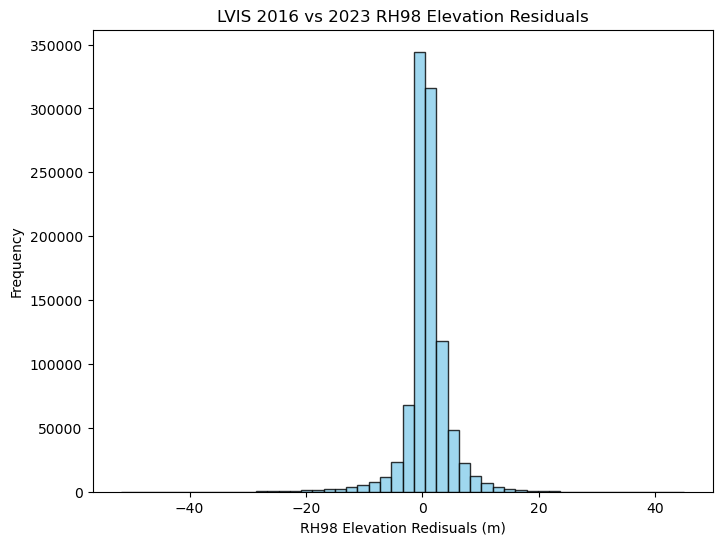

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('LVIS 2016 vs 2023 RH98 Elevation Residuals')
ax.set_xlabel('RH98 Elevation Redisuals (m)')
ax.set_ylabel('Frequency')

ax.hist(xovers['delta'], color='skyblue', edgecolor='black', alpha=0.8, bins=50, log=False)
# ax.set_xlim(min(data1.min(), data2.min()), max(data1.max(), data2.max()))
plt.show()

In [64]:
print(xovers['delta'].mean())
print(xovers['delta'].std())

0.7710627629887068
3.7667594332122705


# GLAD

In [65]:
# read GLAD forest change data and match with LVIS shots
with rasterio.open('glad/gabon_lossyear.tif') as src:
    glad_lossyear = src.read(1)
    raster_mask = glad_lossyear>16
    glad_lossyear[~raster_mask] = 0
    with rasterio.open('glad/gabon_lossyear_filtered.tif', 'w', **src.profile) as dst:
        dst.write(glad_lossyear, 1)

with rasterio.open('glad/gabon_gain.tif') as src:
    glad_gain = src.read(1)
    glad_gain[~raster_mask] = 0
    with rasterio.open('glad/gabon_gain_filtered.tif', 'w', **src.profile) as dst:
        dst.write(glad_gain, 1)

with rasterio.open('glad/gabon_loss.tif') as src:
    glad_loss = src.read(1)
    glad_loss[~raster_mask] = 0
    with rasterio.open('glad/gabon_loss_filtered.tif', 'w', **src.profile) as dst:
        dst.write(glad_loss, 1)

with rasterio.open('glad/gabon_treecover2000.tif') as src:
    glad_treecover = src.read(1)
    crs = src.crs
    transform = src.transform
    width = src.width
    height = src.height
    bounds = src.bounds
    row, col = src.index(xovers['GLON_1'].values, xovers['GLAT_1'].values)
    profile = src.profile
    glad_treecover = src.read(1)
    glad_treecover[~raster_mask] = 0
    with rasterio.open('glad/gabon_treecover2000_filtered.tif', 'w', **src.profile) as dst:
        dst.write(glad_treecover, 1)

# aggregate

In [67]:
x_coords = xovers.GLON_1.values
y_coords = xovers.GLAT_1.values

cols, rows = ~transform * (x_coords, y_coords)
rows = np.floor(rows).astype(int)
cols = np.floor(cols).astype(int)

xovers['cell'] = list(zip(rows, cols))

In [68]:
xovers.columns

Index(['GLAT_1', 'GLON_1', 'INCIDENTANGLE_1', 'LFID_1', 'RH98_1',
       'SHOTNUMBER_1', 'ZG_1', 'ZT_1', 'Z1023_1', 'Z0_1', 'RXWAVE_1', 'GLAT_2',
       'GLON_2', 'INCIDENTANGLE_2', 'LFID_2', 'RH98_2', 'SHOTNUMBER_2', 'ZG_2',
       'ZT_2', 'Z1023_2', 'Z0_2', 'RXWAVE_2', 'RHE98_1', 'RHE98_2', 'delta',
       'RH98_2_new', 'cell'],
      dtype='object')

In [70]:
cols = ['RH98_1',
        'RH98_2',
        'RH98_2_new',
        'delta',
       'cell']

# aggregated_df = xovers[cols].groupby('cell').size().reset_index(name='count')
aggregated_df = xovers[cols].groupby('cell').mean().reset_index()

In [71]:
aggregated_df

,cell,RH98_1,RH98_2,RH98_2_new,delta
0,"(2073, 15598)",33.40,34.60,34.25,0.85
1,"(2073, 15599)",38.62,36.15,34.21,-4.41
2,"(2074, 15597)",60.24,28.10,45.06,-15.18
3,"(2074, 15598)",30.42,33.30,33.08,2.66
4,"(2074, 15600)",37.96,38.62,38.03,0.07
...,...,...,...,...,...
801678,"(16825, 5739)",46.89,48.69,49.08,2.19
801679,"(16826, 5736)",48.85,38.14,46.18,-2.67
801680,"(16826, 5737)",47.90,58.09,55.93,8.03
801681,"(16826, 5738)",41.63,47.49,42.50,0.87


## project to GLAD

In [72]:
rh98_change_array = np.full((height, width), -9999, dtype=np.float32)

for _, row in aggregated_df.iterrows():
    rh98_change_array[row['cell'][0], row['cell'][1]] = row['delta']
    
new_profile = profile.copy()
new_profile.update(
    dtype='float32',
    nodata=-9999,
    count=1
)

with rasterio.open('rh98_change.tif', 'w', **new_profile) as dst:
    dst.write(rh98_change_array, 1)

# add GLAD to dataframe

In [73]:
lossyear_list = []
loss_list = []
gain_list = []
for _, row in aggregated_df.iterrows():
    lossyear_list.append(glad_lossyear[row['cell'][0], row['cell'][1]])
    loss_list.append(glad_loss[row['cell'][0], row['cell'][1]])
    gain_list.append(glad_gain[row['cell'][0], row['cell'][1]])
    
aggregated_df['glad_lossyear'] = lossyear_list
aggregated_df['glad_loss'] = loss_list
aggregated_df['glad_gain'] = gain_list

In [74]:
aggregated_df

,cell,RH98_1,RH98_2,RH98_2_new,delta,glad_lossyear,glad_loss,glad_gain
0,"(2073, 15598)",33.40,34.60,34.25,0.85,0,0,0
1,"(2073, 15599)",38.62,36.15,34.21,-4.41,0,0,0
2,"(2074, 15597)",60.24,28.10,45.06,-15.18,0,0,0
3,"(2074, 15598)",30.42,33.30,33.08,2.66,0,0,0
4,"(2074, 15600)",37.96,38.62,38.03,0.07,0,0,0
...,...,...,...,...,...,...,...,...
801678,"(16825, 5739)",46.89,48.69,49.08,2.19,0,0,0
801679,"(16826, 5736)",48.85,38.14,46.18,-2.67,0,0,0
801680,"(16826, 5737)",47.90,58.09,55.93,8.03,0,0,0
801681,"(16826, 5738)",41.63,47.49,42.50,0.87,0,0,0


# height transition matrix

In [75]:
ranges = [[0, 5],
            [5, 10],
            [10, 15],
            [15, 20],
            [20, 25],
            [25, 30],
            [30, 35],
            [35, 40],
            [40, 45],
          [45, 100],
         ]

rh98_1 = aggregated_df['RH98_1'].values
rh98_2 = aggregated_df['RH98_2_new'].values
delta = aggregated_df['delta'].values
glad_loss = aggregated_df['glad_lossyear'].values>16

In [79]:
matrix = []
sums = []
matrix2 = []
for range1 in ranges:
    mask1 = np.logical_and(rh98_1>range1[0], rh98_1<range1[1])
    sums.append(np.sum(mask1))
    row = []
    row2 = []
    for range2 in ranges:
        mask2 = np.logical_and(rh98_2>range2[0], rh98_2<range2[1])
        mask = np.logical_and(mask1, mask2)
        row.append([np.sum(mask)/np.sum(mask1)])
        row2.append([np.mean(delta[mask]), np.sum(glad_loss[mask])])
    matrix.append(row)
    matrix2.append(row2)
matrix = np.array(matrix)
matrix2 = np.array(matrix2)

/gpfs/data1/vclgp/aghdamim/envs/env4/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/gpfs/data1/vclgp/aghdamim/envs/env4/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


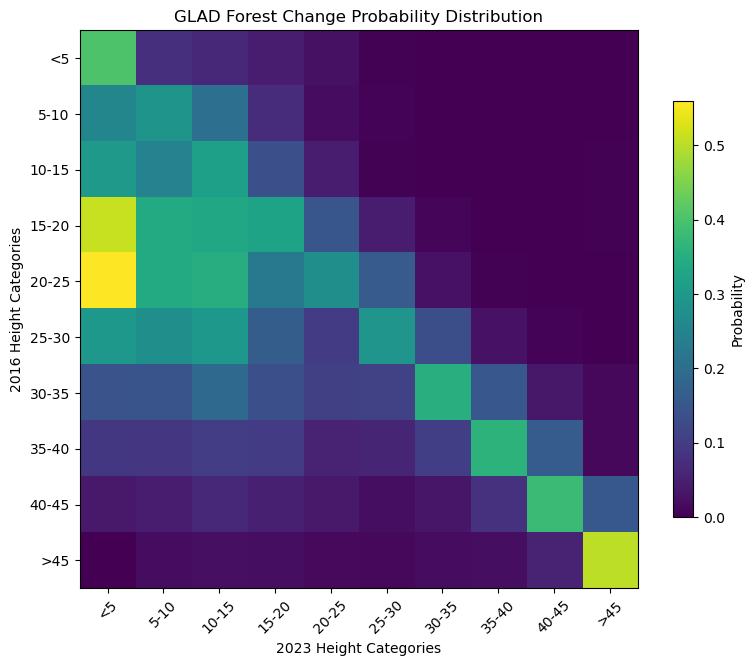

In [80]:
plt.figure(figsize=(9, 9))
normalized_matrix = matrix2[:, :, -1]/np.sum(matrix2[:, :, -1], axis=1)
plt.imshow(normalized_matrix, aspect='equal', cmap='viridis')

labels = ['<5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '>45']

plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)  # Rotate x labels if needed
plt.yticks(ticks=range(len(labels)), labels=labels)

plt.xlabel("2023 Height Categories")
plt.ylabel("2016 Height Categories")
plt.title("GLAD Forest Change Probability Distribution")

cbar = plt.colorbar(shrink=0.6, aspect=20)
cbar.set_label("Probability")
plt.show()

# scenario1: deforestation

In [86]:
sc1_mask = delta<=-5
sc1_df = aggregated_df[sc1_mask].reset_index(drop=True)

In [87]:
sc1_df

,cell,RH98_1,RH98_2,RH98_2_new,delta,glad_lossyear,glad_loss,glad_gain
0,"(2074, 15597)",60.24,28.10,45.06,-15.18,0,0,0
1,"(2087, 15652)",41.15,31.15,29.13,-12.02,0,0,0
2,"(2087, 15653)",38.39,27.26,26.33,-12.06,0,0,0
3,"(2095, 15628)",21.51,15.99,15.28,-6.23,0,0,0
4,"(2095, 15650)",47.73,18.03,40.26,-7.47,0,0,0
...,...,...,...,...,...,...,...,...
29468,"(16819, 5726)",54.89,27.18,33.32,-21.57,0,0,0
29469,"(16820, 5729)",45.14,30.12,34.60,-10.54,0,0,0
29470,"(16820, 5731)",52.12,43.80,41.68,-10.44,0,0,0
29471,"(16821, 5726)",59.63,50.65,47.98,-11.65,0,0,0


In [88]:
from sklearn.metrics import recall_score
print(recall_score(sc1_df['glad_loss'].values, np.full(len(sc1_df), 1)))

print(len(sc1_df)/len(aggregated_df))
print('\n')
print(sc1_df['glad_loss'].sum())
print(sc1_df['glad_loss'].sum()/len(sc1_df))
print('\n')
print(np.mean(sc1_df['delta']))
print(np.std(sc1_df['delta']))

1.0
0.03676390792869501


2517
0.08540019679028263


-10.282202135772371
5.45182780340929


In [89]:
sc1_array = np.full((height, width), -9999, dtype=np.float32)

for _, row in sc1_df.iterrows():
    sc1_array[row['cell'][0], row['cell'][1]] = row['delta']

new_profile = profile.copy()
new_profile.update(
    dtype='float32',
    nodata=-9999,
    count=1
)

with rasterio.open('rasters/sc1_array.tif', 'w', **new_profile) as dst:
    dst.write(sc1_array, 1)

# scenario2: height loss

In [93]:
sc2_mask = np.logical_and(delta>-5, delta<=-0.5)
sc2_df = aggregated_df[sc2_mask].reset_index(drop=True)

In [94]:
sc2_df

,cell,RH98_1,RH98_2,RH98_2_new,delta,glad_lossyear,glad_loss,glad_gain
0,"(2073, 15599)",38.620,36.15,34.21,-4.410,0,0,0
1,"(2074, 15602)",41.020,34.43,40.31,-0.710,0,0,0
2,"(2075, 15596)",47.390,39.66,45.49,-1.900,0,0,0
3,"(2076, 15601)",49.570,45.28,45.97,-3.600,0,0,0
4,"(2078, 15604)",34.260,32.59,32.59,-1.670,0,0,0
...,...,...,...,...,...,...,...,...
160941,"(16820, 5732)",51.990,18.98,50.38,-1.610,0,0,0
160942,"(16820, 5735)",45.855,35.48,44.63,-1.225,0,0,0
160943,"(16824, 5737)",48.200,31.29,44.10,-4.100,0,0,0
160944,"(16825, 5737)",54.030,39.09,52.36,-1.670,0,0,0


In [96]:
print(recall_score(sc2_df['glad_loss'].values, np.full(len(sc2_df), 1)))

print(len(sc2_df)/len(aggregated_df))
print('\n')
print(sc2_df['glad_loss'].sum())
print((len(sc2_df) - sc2_df['glad_loss'].sum())/len(sc2_df))
print('\n')
print(np.mean(sc2_df['delta']))
print(np.std(sc2_df['delta']))

1.0
0.20076015083268572


1209
0.9924881637319349


-1.6355471475792231
1.0792786998507093


In [97]:
sc2_array = np.full((height, width), -9999, dtype=np.float32)

for _, row in sc2_df.iterrows():
    sc2_array[row['cell'][0], row['cell'][1]] = row['delta']

new_profile = profile.copy()
new_profile.update(
    dtype='float32',
    nodata=-9999,
    count=1
)

with rasterio.open('rasters/sc2_array.tif', 'w', **new_profile) as dst:
    dst.write(sc2_array, 1)

# scenario3: no change

In [98]:
sc3_mask = np.logical_and(delta>-0.5, delta<=0.5)
sc3_df = aggregated_df[sc3_mask].reset_index(drop=True)

In [99]:
sc3_df

,cell,RH98_1,RH98_2,RH98_2_new,delta,glad_lossyear,glad_loss,glad_gain
0,"(2074, 15600)",37.960000,38.620000,38.030000,0.07,0,0,0
1,"(2075, 15600)",43.350000,43.290000,43.670000,0.32,0,0,0
2,"(2080, 15604)",38.610000,32.890000,38.370000,-0.24,0,0,0
3,"(2083, 15605)",32.870000,33.490000,32.870000,0.00,0,0,0
4,"(2083, 15609)",31.346667,32.433333,31.836667,0.49,0,0,0
...,...,...,...,...,...,...,...,...
191968,"(16818, 5732)",44.090000,22.660000,44.580000,0.49,0,0,0
191969,"(16820, 5745)",49.210000,43.420000,48.740000,-0.47,0,0,0
191970,"(16822, 5733)",32.190000,32.560000,32.680000,0.49,0,0,0
191971,"(16823, 5737)",45.610000,41.340000,45.460000,-0.15,0,0,0


In [100]:
print(recall_score(sc3_df['glad_loss'].values, np.full(len(sc3_df), 1)))

print(len(sc3_df)/len(aggregated_df))
print('\n')
print(sc3_df['glad_loss'].sum())
print((len(sc3_df) - sc3_df['glad_loss'].sum())/len(sc3_df))
print('\n')
print(np.mean(sc3_df['delta']))
print(np.std(sc3_df['delta']))

1.0
0.23946248080600438


587
0.9969422783412251


0.010763397283298464
0.2815864610301914


In [101]:
sc3_array = np.full((height, width), -9999, dtype=np.float32)

for _, row in sc3_df.iterrows():
    sc3_array[row['cell'][0], row['cell'][1]] = row['delta']

new_profile = profile.copy()
new_profile.update(
    dtype='float32',
    nodata=-9999,
    count=1
)

with rasterio.open('rasters/sc3_array.tif', 'w', **new_profile) as dst:
    dst.write(sc3_array, 1)

# scenario4: height gain

In [102]:
sc4_mask = np.logical_and(delta>0.5, delta<=5)
sc4_df = aggregated_df[sc4_mask].reset_index(drop=True)

In [103]:
sc4_df

,cell,RH98_1,RH98_2,RH98_2_new,delta,glad_lossyear,glad_loss,glad_gain
0,"(2073, 15598)",33.40,34.60,34.25,0.85,0,0,0
1,"(2074, 15598)",30.42,33.30,33.08,2.66,0,0,0
2,"(2075, 15599)",37.98,38.01,38.80,0.82,0,0,0
3,"(2075, 15607)",31.98,34.53,34.77,2.79,0,0,0
4,"(2076, 15598)",35.52,39.53,36.99,1.47,0,0,0
...,...,...,...,...,...,...,...,...
362836,"(16825, 5733)",45.99,45.47,49.92,3.93,0,0,0
362837,"(16825, 5735)",50.26,38.59,53.77,3.51,0,0,0
362838,"(16825, 5739)",46.89,48.69,49.08,2.19,0,0,0
362839,"(16826, 5738)",41.63,47.49,42.50,0.87,0,0,0


In [104]:
print(recall_score(sc4_df['glad_loss'].values, np.full(len(sc4_df), 1)))

print(len(sc4_df)/len(aggregated_df))
print('\n')
print(sc4_df['glad_loss'].sum())
print((len(sc4_df) - sc4_df['glad_loss'].sum())/len(sc4_df))
print('\n')
print(np.mean(sc4_df['delta']))
print(np.std(sc4_df['delta']))

1.0
0.45259909465462034


1570
0.9956730358476578


1.9621356043923739
1.1376671706606425


In [105]:
sc4_array = np.full((height, width), -9999, dtype=np.float32)

for _, row in sc4_df.iterrows():
    sc4_array[row['cell'][0], row['cell'][1]] = row['delta']

new_profile = profile.copy()
new_profile.update(
    dtype='float32',
    nodata=-9999,
    count=1
)

with rasterio.open('rasters/sc4_array.tif', 'w', **new_profile) as dst:
    dst.write(sc4_array, 1)

# scenario5: reforestation

In [109]:
sc5_mask = delta>=5
sc5_df = aggregated_df[sc5_mask].reset_index(drop=True)

In [110]:
sc5_df

,cell,RH98_1,RH98_2,RH98_2_new,delta,glad_lossyear,glad_loss,glad_gain
0,"(2075, 15595)",34.54,41.77,41.87,7.33,0,0,0
1,"(2076, 15595)",31.71,36.54,36.78,5.07,0,0,0
2,"(2076, 15596)",35.97,41.82,41.36,5.39,0,0,0
3,"(2076, 15605)",23.55,29.80,31.98,8.43,0,0,0
4,"(2077, 15604)",23.77,26.39,28.99,5.22,0,0,0
...,...,...,...,...,...,...,...,...
56579,"(16800, 5736)",30.94,52.81,53.03,22.09,0,0,0
56580,"(16802, 5730)",43.65,48.73,48.73,5.08,0,0,0
56581,"(16811, 5724)",46.80,43.99,56.24,9.44,0,0,0
56582,"(16821, 5734)",39.75,43.44,45.76,6.01,0,0,0


In [111]:
print(recall_score(sc5_df['glad_loss'].values, np.full(len(sc5_df), 1)))

print(len(sc5_df)/len(aggregated_df))
print('\n')
print(sc5_df['glad_loss'].sum())
print((len(sc5_df) - sc5_df['glad_loss'].sum())/len(sc5_df))
print('\n')
print(np.mean(sc5_df['delta']))
print(np.std(sc5_df['delta']))

1.0
0.07058151413962875


651
0.9884949809133324


8.112135426975824
3.3830044046065324


In [112]:
sc5_array = np.full((height, width), -9999, dtype=np.float32)

for _, row in sc5_df.iterrows():
    sc5_array[row['cell'][0], row['cell'][1]] = row['delta']

new_profile = profile.copy()
new_profile.update(
    dtype='float32',
    nodata=-9999,
    count=1
)

with rasterio.open('rasters/sc5_array.tif', 'w', **new_profile) as dst:
    dst.write(sc5_array, 1)

# make gif

In [113]:
im_stack = []
for fname in ['ims/new/project5_1.png', 'ims/new/project5_2.png', 'ims/new/project5_3.png', 'ims/new/project5_4.png', 'ims/new/project5_5.png','ims/new/project5_6.png','ims/new/project5_7.png',]:
    im_stack.append(plt.imread(fname))

In [114]:
im_stack[0].shape

(2117, 3434, 4)

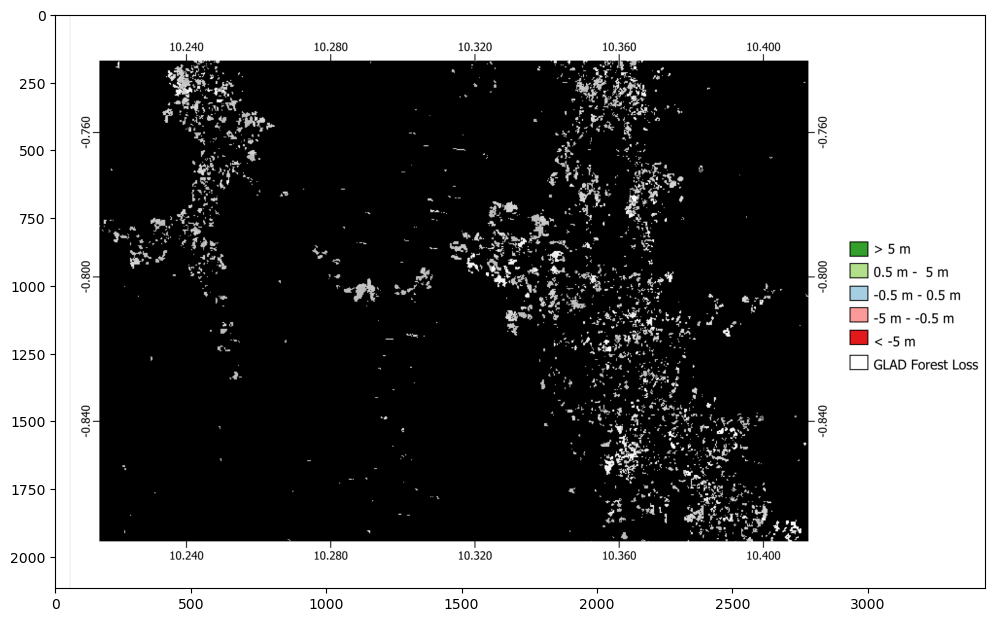

In [115]:
plt.figure(figsize=(12, 8))
plt.imshow(im_stack[0])
plt.show()

In [118]:
import imageio

titles = ['GLAD Forest Loss', 'Deforestation', 'Canopy Height Loss', 'No Change', 'Canopy Height Gain', 'Reforestation', 'All']

# Create the GIF frames
gif_frames = []
for i, (title, image) in enumerate(zip(titles, im_stack)):
    # Create a plot for each image
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image)
    ax.axis('off')  # Hide axes
    ax.set_title(title, fontsize=16)  # Add a title to each frame
    
    # Save the plot to a temporary file
    temp_filename = f"ims/gif/temp_frame_{i}.png"
    plt.savefig(temp_filename, bbox_inches='tight', pad_inches=0.1, dpi=500)
    plt.close(fig)  # Close the figure to avoid memory issues
    
    # Read the saved plot and add to GIF frames
    gif_frames.append(imageio.imread(temp_filename))
    
    # Clean up temporary files
    os.remove(temp_filename)

output_gif = "ims/new/project5.gif"
imageio.mimsave(output_gif, gif_frames, duration=1400, loop=0)

print(f"GIF saved as {output_gif}")

/tmp/ipykernel_190952/2439562248.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gif_frames.append(imageio.imread(temp_filename))


GIF saved as ims/new/project5.gif
